In [245]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder

import os
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import os
import pathlib
import codecs

Check which versions of Tensorflow and Sci-kit learn are in use so that documentation is easier to use when we get stuck.

In [246]:
tf.__version__, sklearn.__version__

('1.11.0', '0.19.1')

Grab MNIST data using tensorflow (this may take a minute).

In [247]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Check out the size of each dataset. It looks like the train:test ratio is 6:1, with the test data being one column.

In [248]:
x_train.shape, x_test.shape, y_train.shape

((60000, 28, 28), (10000, 28, 28), (60000,))

In [249]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Check the distribution of labels to ensure that we are using a balanced training set.

Text(0.5,0,'Label')

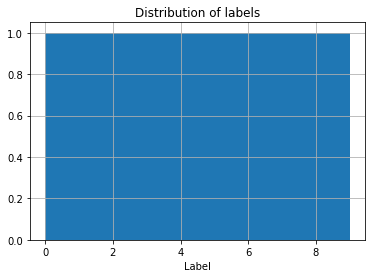

In [250]:
pd.Series(y_train).value_counts().reset_index().hist('index')
plt.title("Distribution of labels")
plt.xlabel('Label')

Since the y data has many classes, let's one-hot encode it with sci-kit learn.

In [251]:
oneH = OneHotEncoder()
oneH.fit(y_train.reshape(-1, 1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [252]:
ohYTest = oneH.transform(y_test.reshape(-1,1)).toarray()
ohYTrain = oneH.transform(y_train.reshape(-1,1)).toarray()

The train and test labels are now stored in sparse matrices. A quick unit test below ensures that the transformation was performed correctly. The printed data should support your intuition as to what the test is doing.

In [253]:
print("Transformed label:")
print(ohYTrain[0])
print()
print("Original label:")
print(y_train[0])

Transformed label:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

Original label:
5


In [254]:
for i in range(y_train.shape[0]):
    assert np.argmax(ohYTrain[i]) == y_train[i]

Just for a sanity check, let's make sure the first data point is actually a 5. Matplotlib supports plotting images, so let's leverage its power.

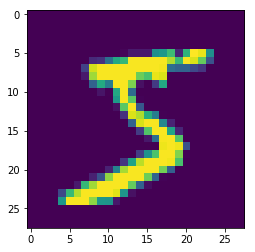

In [255]:
plt.imshow(x_train[0]);

This looks great. Let's examine the shape of each image's matrix to plan for our modelling process.

In [256]:
x_train[0].shape

(28, 28)

Let's prepare our model in tensorflow, including ensuring that the computational graph is ready to be used from scratch.

In [346]:
import keras
from keras import layers, models
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [359]:
## Graveyard of Ideas ##

#  with tf.name_scope("Dense_L2_Reg"):
#         model.add(layers.Dense(100, activation=tf.nn.))
#         model.add(layers.Dropout(0.10))
        
# with tf.name_scope("Batch_Norm"):
#         model.add(layers.BatchNormalization())
    
# with tf.name_scope("Dense_Leaky"):
#     model.add(layers.Dense(2000, activation=tf.nn.leaky_relu))
#     model.add(layers.Dropout(0.10))

    
#     with tf.name_scope("Dense_Leaky"):
#         model.add(layers.Dense(800))
#         model.add(layers.BatchNormalization())
#         model.add(layers.LeakyReLU())
#         model.add(layers.Dropout(0.10))

#     with tf.name_scope("Dense_Leaky"):
#         model.add(layers.Dense(200))
#         model.add(layers.BatchNormalization())
#         model.add(layers.LeakyReLU())
#         model.add(layers.Dropout(0.10))

#     with tf.name_scope("Dense_Leaky"):
#         model.add(layers.Dense(100))
#         model.add(layers.BatchNormalization())
#         model.add(layers.LeakyReLU())
#         model.add(layers.Dropout(0.10))

# with tf.name_scope("Image_Augmentation"):
#     imAug = ImageDataGenerator(zoom_range = 0.1,
#                             height_shift_range = 0.1,
#                             width_shift_range = 0.1,
#                             rotation_range = 10)

#     model.fit_generator(imAug.flow(x_train, ohYTrain, batch_size=batchSize),
#                            steps_per_epoch=500,
#                            epochs=epochs, #Increase this when not on Kaggle kernel
#                            verbose=2,  #1 for ETA, 0 for silent
#                            validation_data=(x_test[:400,:], ohYTest[:400,:]), #For speed
#                            callbacks=[tensorBoard, adaptLR])


In [348]:
tf.reset_default_graph()
K.clear_session()

sess = tf.Session(graph=tf.get_default_graph())

with tf.name_scope("Improved_Model"):

    model = keras.models.Sequential()

    with tf.name_scope("Input_Flatten"):
        model.add(layers.Flatten(input_shape=(28,28,)))

    with tf.name_scope("Dense_Leaky"):
        model.add(layers.Dense(758))
        model.add(layers.LeakyReLU())

    with tf.name_scope("Dense_Leaky"):
        model.add(layers.Dense(128) )
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.15))
        
    with tf.name_scope("Dense_Leaky"):
        model.add(layers.Dense(32))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.10))

    with tf.name_scope("Output"):
        model.add(layers.Dense(output_dim = 10, name="Output"))
        model.add(layers.Softmax())

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 758)               595030    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 758)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               97152     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [349]:
with tf.name_scope("tBoard_Setup"):
    tensorBoard = keras.callbacks.TensorBoard(log_dir="./improved_logs", histogram_freq=1, write_graph=True)
    tensorBoard.set_model(model)

In [350]:
with tf.name_scope("Adaptive_Learning_Rate"):
    
    adaptLR = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x, verbose=1)

In [351]:
logDir = "improved_logs"
logPath = (os.getcwd() + "/" + logDir).replace(" ", "\\ ")
print("Path for Tensorboard Logs:")
print(logPath)

Path for Tensorboard Logs:
/Users/mikelawrence/Documents/School/Data\ X/HW/HW\ 10/improved_logs


In [352]:
with tf.name_scope("Compilation"):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [353]:
batchSize = 20
epochs = 25

In [354]:
with tf.name_scope('Training'):
    model.fit(x=x_train, y=ohYTrain, verbose=1, shuffle=True, batch_size=batchSize, nb_epoch=epochs,
              callbacks=[tensorBoard, adaptLR], validation_data=(x_test, ohYTest))


Train on 60000 samples, validate on 10000 samples
Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
60000/60000 [==============================] - 70s 1ms/step - loss: 0.3093 - acc: 0.9115 - val_loss: 0.1589 - val_acc: 0.9508
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009000000000000001.
60000/60000 [==============================] - 68s 1ms/step - loss: 0.1626 - acc: 0.9506 - val_loss: 0.1169 - val_acc: 0.9627
Epoch 3/25

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0008100000000000001.
60000/60000 [==============================] - 68s 1ms/step - loss: 0.1282 - acc: 0.9607 - val_loss: 0.0859 - val_acc: 0.9726
Epoch 4/25

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0007290000000000002.
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1010 - acc: 0.9690 - val_loss: 0.0840 - val_acc: 0.9747
Epoch 5/25

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000

In [355]:
with tf.name_scope("Evaluation"):
    print("Final Train Loss and Accuracy are:")
    print(model.evaluate(x_train, ohYTrain, verbose=0))
    print()
    print("Final Test Loss and Accuracy are:")
    print(model.evaluate(x_test, ohYTest, verbose=0))

Final Train Loss and Accuracy are:
[0.0010037639418595669, 0.99985]

Final Test Loss and Accuracy are:
[0.05703200456253835, 0.9861]


In [356]:
print(logPath)

/Users/mikelawrence/Documents/School/Data\ X/HW/HW\ 10/improved_logs


In [358]:
!tensorboard --logdir=/Users/mikelawrence/Documents/School/Data\ X/HW/HW\ 10/improved_logs #--port=6005